In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [2]:
#Import important libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')

In [4]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
df.shape

(1460, 81)

# 1. Data Manipulation
## 1.1 Manipulating NaN values

In [6]:
null = []

for feature in df.columns:
    if df[feature].isnull().sum() > 0:
        null.append(feature)

null

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [7]:
df[null].isnull().sum()

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [8]:
df['MiscFeature'].tail()

1455     NaN
1456     NaN
1457    Shed
1458     NaN
1459     NaN
Name: MiscFeature, dtype: object

In [9]:
df = df.drop(columns = ['PoolQC', 'Alley', 'Fence', 'MiscFeature'])

In [10]:
df.shape

(1460, 77)

We have dropped the columns which had over 1000 missing values.

In [11]:
null2 = []

for feature in df.columns:
    if df[feature].isnull().sum() > 0:
        null2.append(feature)

df[null2].isnull().sum()

LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

This are the columns which still have null values. We have to manipulate them in order to remove the null values.

### 1.1.1 Feature: Lot Frontage

We are going to replace the 259 missing values with the mean of the LotFrontage of the whole dataframe

In [12]:
df['LotFrontage'].mean()

70.04995836802665

In [13]:
df['LotFrontage'].fillna(df['LotFrontage'].mean(), inplace = True)

In [14]:
df['LotFrontage'].isnull().sum()

0

### 1.1.2 Feature: MasVnrType & MasVnrArea

We are going to replace the NaN values for None value, meaning they don't have masonry veneer type.

In [15]:
df['MasVnrType'].value_counts()

None       864
BrkFace    445
Stone      128
BrkCmn      15
Name: MasVnrType, dtype: int64

In [16]:
df['MasVnrType'].fillna('None', inplace = True)

In [17]:
df['MasVnrArea'].mean()

103.68526170798899

In [18]:
df['MasVnrArea'].fillna(df['MasVnrArea'].mean(), inplace = True)

In [19]:
print(df['MasVnrType'].isnull().sum())
print(df['MasVnrArea'].isnull().sum())

0
0


### 1.1.3 Feature: Basement Features (BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2)

In [20]:
bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2']
df[bsmt].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2
0,Gd,TA,No,GLQ,706,Unf
1,Gd,TA,Gd,ALQ,978,Unf
2,Gd,TA,Mn,GLQ,486,Unf
3,TA,Gd,No,ALQ,216,Unf
4,Gd,TA,Av,GLQ,655,Unf


All,  except BsmtFinSF1, are categorical values. Therefore, we are going to replace this valus for 'None', assuming there is no basement.

In [21]:
bsmt1 = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[bsmt1].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf


In [22]:
for col in df[bsmt1].columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna('None', inplace = True)

df[bsmt1].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

We have replaced all null values with 'None'.

Now we must manipualte the 'BsmtFinType1' feature for the mean

In [23]:
df['BsmtFinType1'].fillna(df['BsmtFinSF1'].mean(), inplace = True)
df['BsmtFinSF1'].isnull().sum()

0

#### Which features are remaining?

In [24]:
df[null2].isnull().sum()

LotFrontage       0
MasVnrType        0
MasVnrArea        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinType2      0
Electrical        1
FireplaceQu     690
GarageType       81
GarageYrBlt      81
GarageFinish     81
GarageQual       81
GarageCond       81
dtype: int64

### 1.1.4 Feature: Electrical

As we just have 1 missing value, we'll replace it with the mode

In [25]:
print(df['Electrical'].isnull().sum())
print(df['Electrical'].mode())

1
0    SBrkr
dtype: object


In [26]:
df['Electrical'].fillna('SBrkr', inplace = True)
df['Electrical'].isnull().sum()

0

### 1.1.5 Feature: FireplaceQu

The remaining feature with the most missing valus (690)

As a missing value means there is no fireplace, we'll replace the NaN values with 'None'.

In [27]:
df['FireplaceQu'].fillna('None', inplace = True)
df['FireplaceQu'].isnull().sum()

0

### 1.1.6 Feature: Garages (GarageType, GarageYrBlt, GarageFinish, GarageQual, GarageCond) 

In [28]:
garages = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
df[garages].head()

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond
0,Attchd,2003.0,RFn,TA,TA
1,Attchd,1976.0,RFn,TA,TA
2,Attchd,2001.0,RFn,TA,TA
3,Detchd,1998.0,Unf,TA,TA
4,Attchd,2000.0,RFn,TA,TA


All features, except GarageYrBlt, are categorical.

In [29]:
garages1 = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in df[garages1].columns:
    if df[col].isnull().sum() > 0:
        df[col].fillna('None', inplace = True)

df[garages1].isnull().sum()

GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

Now replace the year built for mode or mean. Let's explore how years are distributed.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GarageYrBlt', ylabel='Density'>

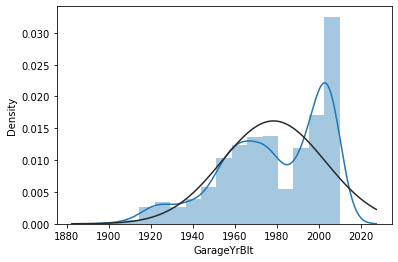

In [30]:
from scipy import stats
from scipy.stats import norm, skew 
sns.distplot(df['GarageYrBlt'], fit  = norm)

In [31]:
print('Year built mode is',str(df['GarageYrBlt'].mode()))
print('Year built mean is',str(df['GarageYrBlt'].mean()))

Year built mode is 0    2005.0
dtype: float64
Year built mean is 1978.5061638868744


We'll replace missing values with the mean

In [32]:
df['GarageYrBlt'].fillna(df['GarageYrBlt'].mean(), inplace = True)
df['GarageYrBlt'].isnull().sum()

0

Let's see how the distribution is now

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='GarageYrBlt', ylabel='Density'>

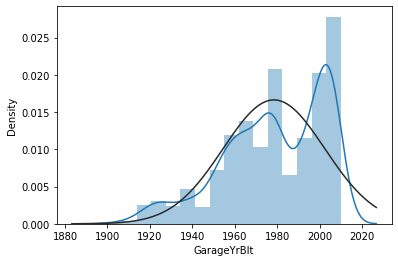

In [33]:
sns.distplot(df['GarageYrBlt'], fit  = norm)

We've added several values, therefore, we've modified the distribution. Not ideal, but simple way to handle missing values

#### Have we remoev all missing values? Lets check

In [34]:
df[null2].isnull().sum()

LotFrontage     0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

---

# 2. Working with numerical and categorical values

## 2.1 Categorical

In [35]:
cat = []

for col in df.columns:
  if df[col].dtype == 'object':
    cat.append(col)

df_cat = df[cat]
df_cat.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [36]:
df_cat = df[cat]
print(df_cat.shape)

(1460, 39)


We must do one-hot-encoding in order to create dummies for the categorical values. This is the only way we'll be able to put them inside our model.

In [37]:
dummies = pd.get_dummies(df_cat)
dummies

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1456,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1457,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1458,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## 2.2 Numerical

In [38]:
num = []

for col in df.columns:
    if df[col].dtypes != 'object':
        num.append(col)
        
df_num = df[num]
df_num.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [39]:
df_num.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.569112,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


---

# 3. Exploration

We'll want to see what are the features that are more highly correlated to SalePrice

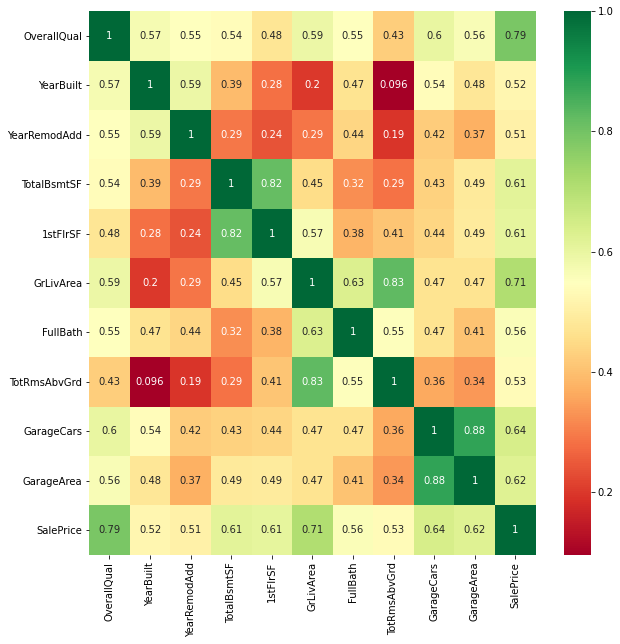

In [40]:
corrmat = df.corr()
top_corr_features = corrmat.index[abs(corrmat['SalePrice'])>0.5]
plt.figure(figsize=(10,10))
g = sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='RdYlGn')

In [41]:
print('We have ',top_corr_features.shape[0], 'features that have a correlation higher than 0.5 with SalePrice')

We have  11 features that have a correlation higher than 0.5 with SalePrice


/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


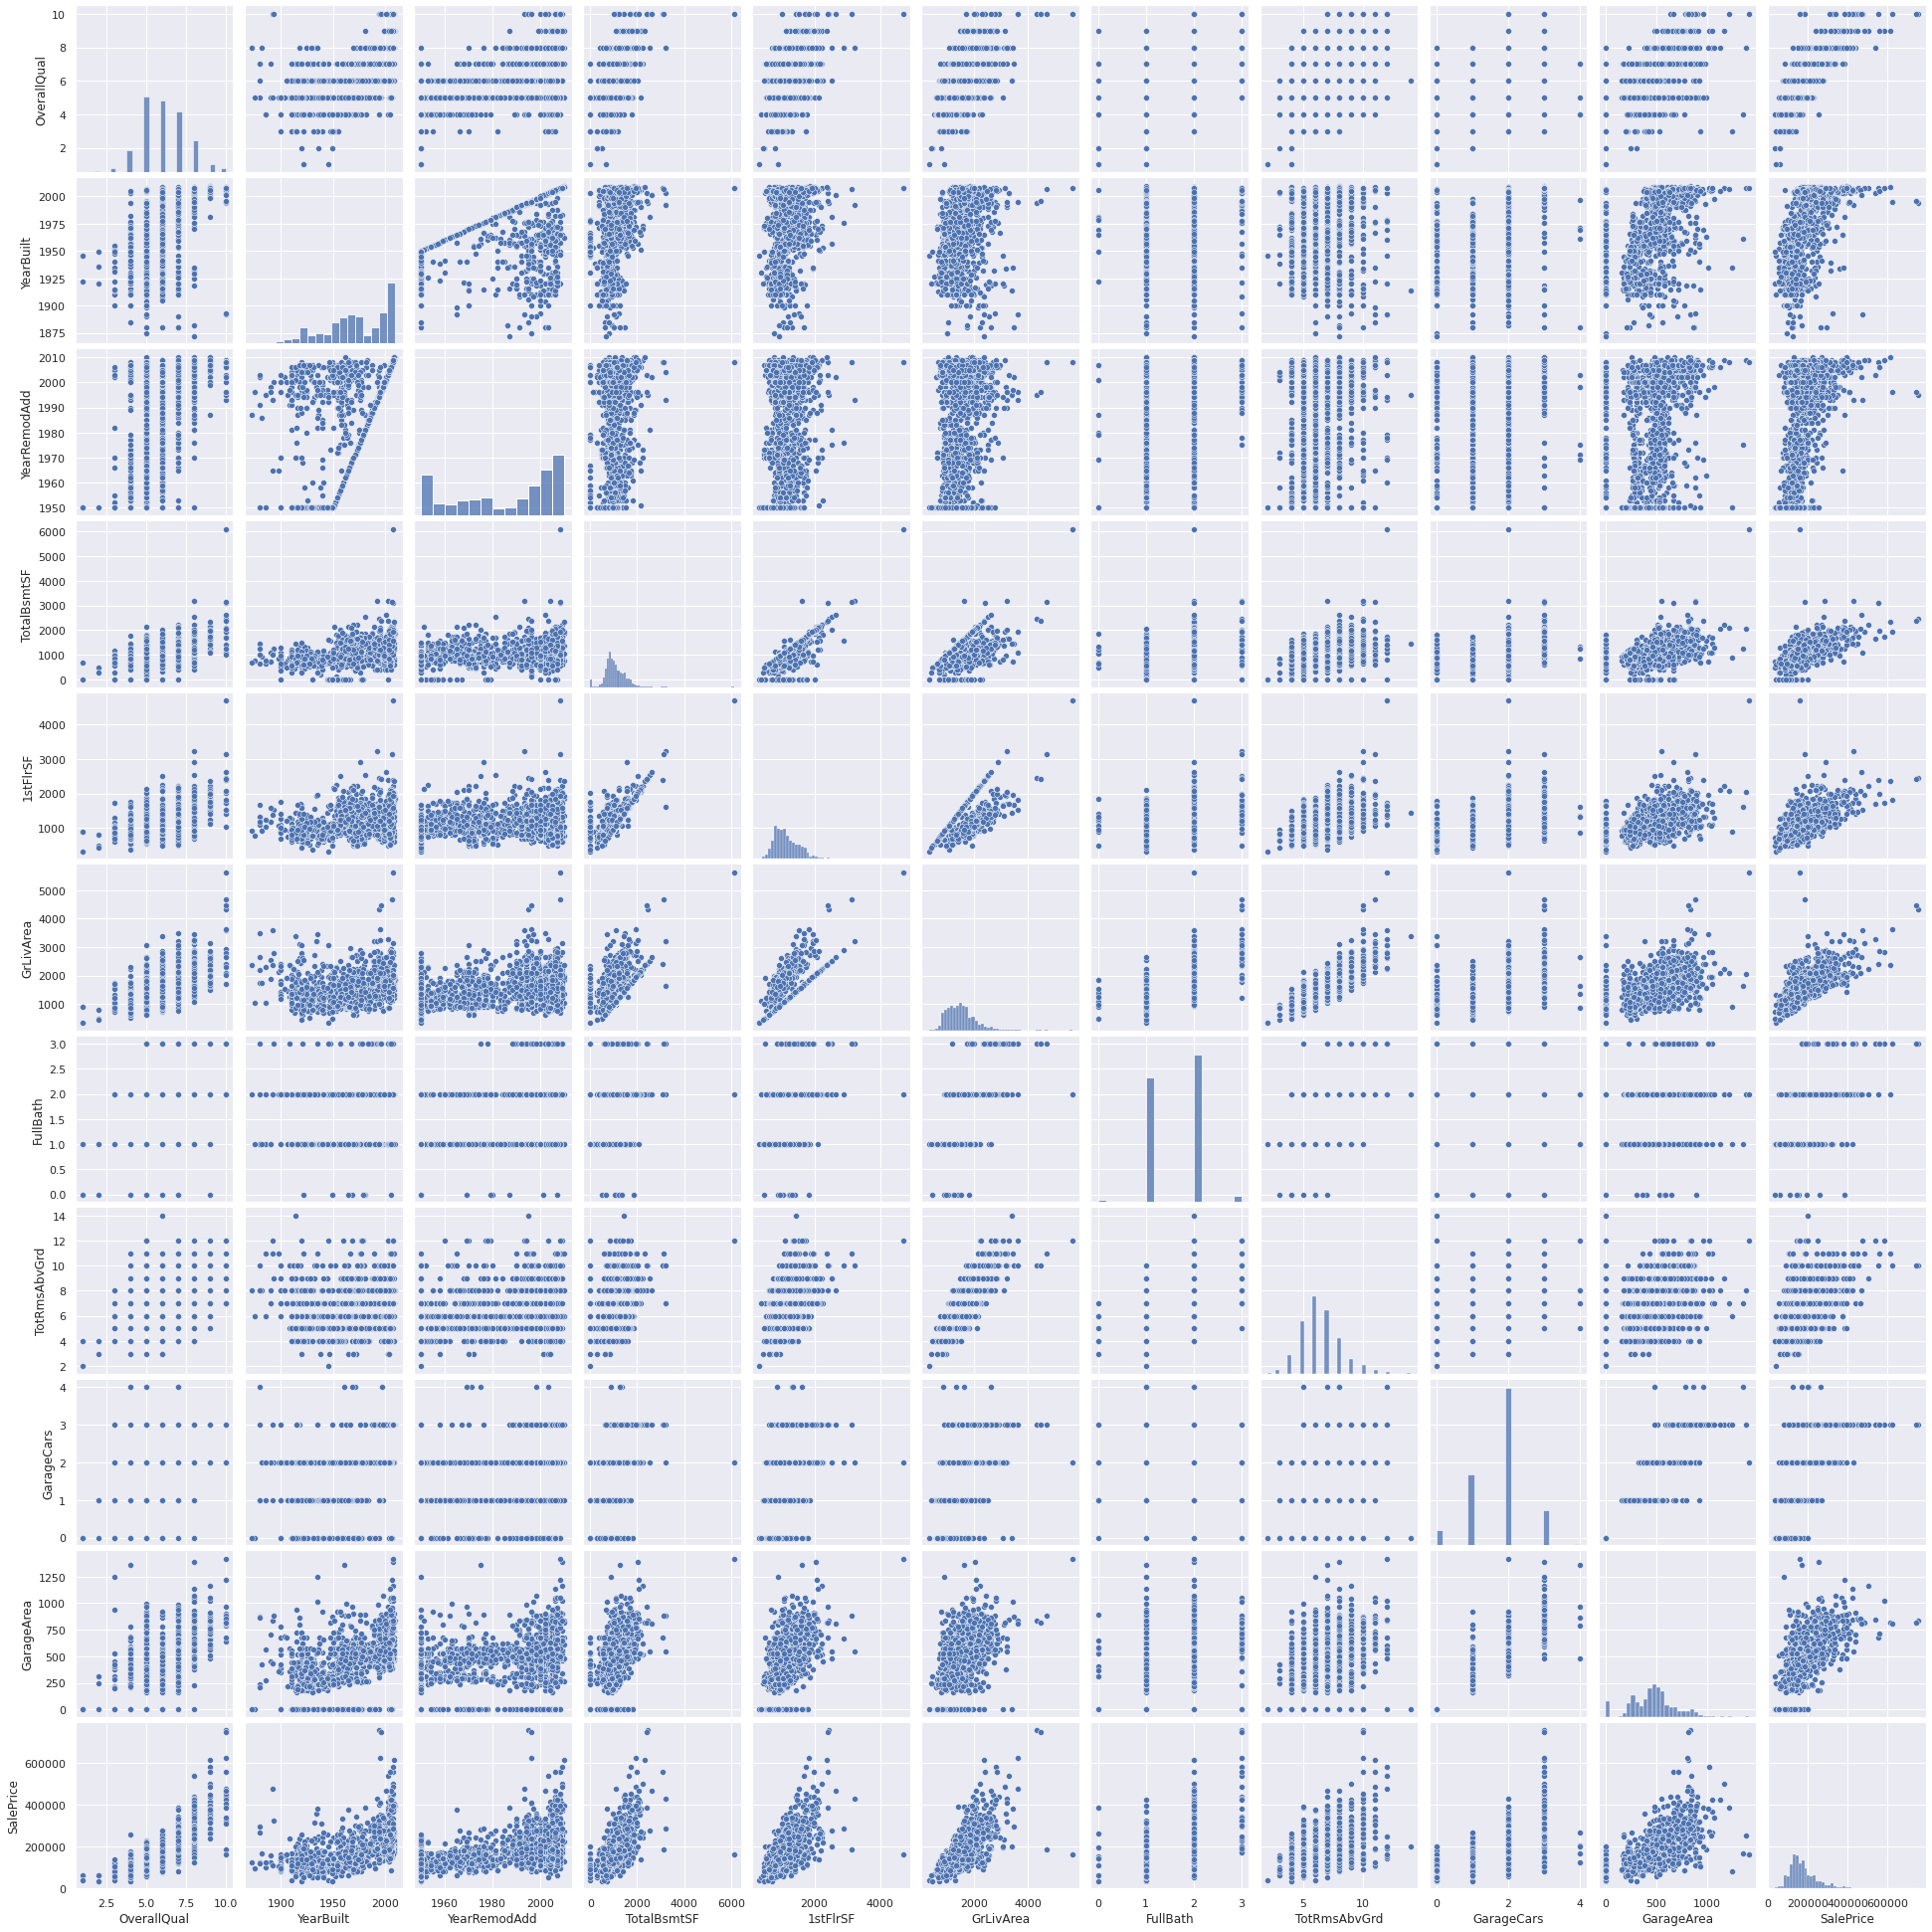

In [42]:
sns.set()
sns.pairplot(df[top_corr_features], size = 2.5)
plt.show();

---

# 4. Prepare data for modeling

## 4.1 Making a complete DataFrame for all the data

We now know that we have the df dummies and df_num which have the values we want. We must put them together.

In [43]:
df_model = pd.concat([df_num, dummies], axis=1)
df_model.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


Now that we have all the features in one DataFrame, we must drop the target variable, and store it on another variable.

In [44]:
X = df_model.drop('SalePrice', axis=1)
y = df_model['SalePrice']

In [45]:
X.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,0,0,1,0,0,0,0,1,0
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,0,0,0,1,0,0,0,0,1,0
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,0,0,1,0,0,0,0,1,0
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,0,0,1,1,0,0,0,0,0
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,0,0,0,1,0,0,0,0,1,0


In [46]:
y.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

---

# 4. Modeling

## 4.1 Linear regression

In [47]:
import numpy as np
from sklearn.linear_model import LinearRegression

import numpy as np
from sklearn.model_selection import train_test_split

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [49]:
reg = LinearRegression()
reg.fit(X_train, y_train)
reg.score(X_train, y_train)

0.9349037539934099

In [50]:
reg_test = LinearRegression()
reg_test.fit(X_test, y_test)
reg_test.score(X_test, y_test)

0.9754688180874069

In [51]:
pred = reg.predict(X_test)
pred_train = reg.predict(X_train)

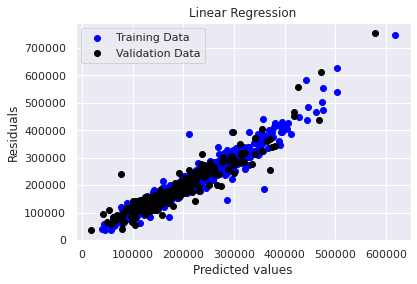

In [52]:
plt.scatter(pred_train, y_train, c = 'blue', label = 'Training Data')
plt.scatter(pred, y_test, c = 'black', label = 'Validation Data')
plt.title('Linear Regression')
plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc = 'upper left')
plt.show()

In [53]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

In [54]:
print(reg.intercept_)
#print(reg.coef_)

-572390.3185885554


Now I want to analyze the coefficients of the model to interpret how some variables affect the model.

In [55]:
all_coef = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])
all_coef.sort_values('Coefficients', ascending=False).head(10)


,Coefficients
RoofMatl_Metal,131098.608631
GarageQual_Ex,124192.378392
RoofMatl_WdShngl,100638.868484
RoofMatl_Tar&Grv,90761.590579
RoofMatl_CompShg,90724.368139
RoofMatl_Roll,90543.317542
RoofMatl_WdShake,90467.414191
Condition2_PosA,87206.340796
RoofStyle_Shed,57828.029009
Condition2_Feedr,47821.991206


This shows us the 10 most important features regarding it's effect on the SalePrice. All of them are related to categorical features, which makes sense because their values are eithere 0 or 1.

For example: if a house has a roof material made out of metal, is's SalePrice is going to be **increased (if all other values are fixed) by $131,098**

Another example: if a house has a garage in excelent quality, is's SalePrice is going to be **increased (if all other values are fixed) by $124,192**

In [56]:
top = top_corr_features[0:-1]
top

Index(['OverallQual', 'YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF',
       'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'GarageCars', 'GarageArea'],
      dtype='object')

In [57]:
coef = pd.DataFrame(reg.coef_, X.columns, columns=['Coefficients'])
coef1 = coef.transpose()
imp_coef_df = coef1[top].transpose().sort_values(by = 'Coefficients',ascending=False)
imp_coef_df

,Coefficients
OverallQual,6741.835143
FullBath,2848.913497
TotRmsAbvGrd,1421.274639
GarageCars,1356.189461
YearBuilt,352.913778
YearRemodAdd,132.128029
GarageArea,30.414530
GrLivArea,30.115784
TotalBsmtSF,25.642166
1stFlrSF,9.965118


#### What does this mean?

**Interpretation of most important coefficients (regarding correlation to SalePrice):**
* If all other features are fixed, an increase in 1 unit in **OverallQuall** is asociated with an **increase of $6741.84** in SalePrice

* If all other features are fixed, an increase in 1 unit in **YearBuilt** is asociated with an **increase of $352.91** in SalePrice

* If all other features are fixed, an increase in 1 unit in **YearRemodAdd** is asociated with an **increase of $132.13** in SalePrice

* And so on with all other values...

## 4.2 Evaluation

In [58]:
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square:', r2_square)
    print('-----------------------------')

In [59]:
#evaluation for train data
evaluate(y_train, pred_train)

MAE: 12767.595112315808
MSE: 388269838.84024096
RMSE: 19704.563908908032
R2 Square: 0.9349037539934099
-----------------------------


In [60]:
#evaluation for test data
evaluate(y_test, pred)

MAE: 18591.929709672495
MSE: 876062345.2938174
RMSE: 29598.350381293505
R2 Square: 0.8857855165960291
-----------------------------


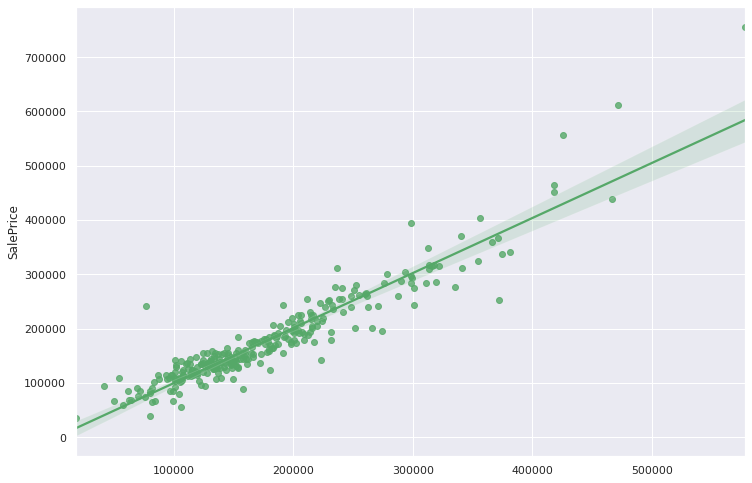

In [61]:
residuals = y_test-pred
#plt.hist(residuals, pred)
a4_dims = (12, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.regplot(x=pred, y=y_test, color='g')
plt.show()


#### Export DF to CSV

In [62]:
df_model.to_csv('df_model.csv')

# 5. Test DataFrame

## 5.1 Data Manipulation 
We must now manipulate all the test dataframe as we have done with the train dataframe in order to be able to predict the values

In [63]:
null = []

for feature in df_test.columns:
    if df_test[feature].isnull().sum() > 0:
        null.append(feature)

null

['MSZoning',
 'LotFrontage',
 'Alley',
 'Utilities',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageCars',
 'GarageArea',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType']

In [64]:
df_test[null].isnull().sum()

MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        16
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
GarageQual        78
GarageCond        78
PoolQC          1456
Fence           1169
MiscFeature     1408
SaleType           1
dtype: int64

In [65]:
df_test = df_test.drop(columns = ['PoolQC', 'Alley', 'Fence', 'MiscFeature'])

In [66]:
df_test.shape

(1459, 76)

In [67]:
null2 = []

for feature in df_test.columns:
    if df_test[feature].isnull().sum() > 0:
        null2.append(feature)

df_test[null2].isnull().sum()

MSZoning          4
LotFrontage     227
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       16
MasVnrArea       15
BsmtQual         44
BsmtCond         45
BsmtExposure     44
BsmtFinType1     42
BsmtFinSF1        1
BsmtFinType2     42
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
FireplaceQu     730
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64

### Lot Frontage

In [68]:
df_test['LotFrontage'].mean()

68.58035714285714

In [69]:
df_test['LotFrontage'].fillna(df_test['LotFrontage'].mean(), inplace = True)

In [70]:
df_test['LotFrontage'].isnull().sum()

0

### MasVnrType & MasVnrArea

In [71]:
df_test['MasVnrType'].value_counts()

None       878
BrkFace    434
Stone      121
BrkCmn      10
Name: MasVnrType, dtype: int64

In [72]:
df_test['MasVnrType'].fillna('None', inplace = True)

In [73]:
df_test['MasVnrArea'].mean()

100.70914127423822

In [74]:
df_test['MasVnrArea'].fillna(df_test['MasVnrArea'].mean(), inplace = True)

In [75]:
print(df_test['MasVnrType'].isnull().sum())
print(df_test['MasVnrArea'].isnull().sum())

0
0


### Basement Features (BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinSF1, BsmtFinType2)

In [76]:
df_test[bsmt].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2
0,TA,TA,No,Rec,468.0,LwQ
1,TA,TA,No,ALQ,923.0,Unf
2,Gd,TA,No,GLQ,791.0,Unf
3,TA,TA,No,GLQ,602.0,Unf
4,Gd,TA,No,ALQ,263.0,Unf


In [77]:
df[bsmt1].head()

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2
0,Gd,TA,No,GLQ,Unf
1,Gd,TA,Gd,ALQ,Unf
2,Gd,TA,Mn,GLQ,Unf
3,TA,Gd,No,ALQ,Unf
4,Gd,TA,Av,GLQ,Unf


In [78]:
for col in df_test[bsmt1].columns:
    if df_test[col].isnull().sum() > 0:
        df_test[col].fillna('None', inplace = True)

df_test[bsmt1].isnull().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
dtype: int64

In [79]:
df_test['BsmtFinSF1'].fillna(df_test['BsmtFinSF1'].mean(), inplace = True)
df_test['BsmtFinSF1'].isnull().sum()

0

#### What are the remaining features with null values for test?

In [80]:
df_test[null2].isnull().sum()

MSZoning          4
LotFrontage       0
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType        0
MasVnrArea        0
BsmtQual          0
BsmtCond          0
BsmtExposure      0
BsmtFinType1      0
BsmtFinSF1        0
BsmtFinType2      0
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
FireplaceQu     730
GarageType       76
GarageYrBlt      78
GarageFinish     78
GarageCars        1
GarageArea        1
GarageQual       78
GarageCond       78
SaleType          1
dtype: int64

### Electrical

In [81]:
print(df_test['Electrical'].isnull().sum())
print(df_test['Electrical'].mode())

0
0    SBrkr
dtype: object


In [82]:
df_test['Electrical'].fillna('SBrkr', inplace = True)
df_test['Electrical'].isnull().sum()

0

### FireplaceQu

In [83]:
df_test['FireplaceQu'].fillna('None', inplace = True)
df_test['FireplaceQu'].isnull().sum()

0

In [84]:
garages_test = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageCars', 'GarageArea']
df_test[garages_test].head()

,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,GarageCars,GarageArea
0,Attchd,1961.0,Unf,TA,TA,1.0,730.0
1,Attchd,1958.0,Unf,TA,TA,1.0,312.0
2,Attchd,1997.0,Fin,TA,TA,2.0,482.0
3,Attchd,1998.0,Fin,TA,TA,2.0,470.0
4,Attchd,1992.0,RFn,TA,TA,2.0,506.0


In [85]:
garages_test_cat = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
garages_test_num = ['GarageYrBlt', 'GarageCars', 'GarageArea']

for col in df_test[garages_test_cat].columns:
    if df_test[col].isnull().sum() > 0:
        df_test[col].fillna('None', inplace = True)

df_test[garages_test_cat].isnull().sum()

GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


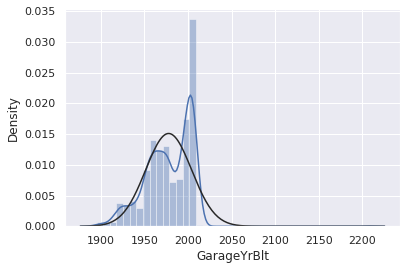

Mean of  GarageYrBlt 1977.7212165097756
Mode of  GarageYrBlt 0    2005.0
dtype: float64


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


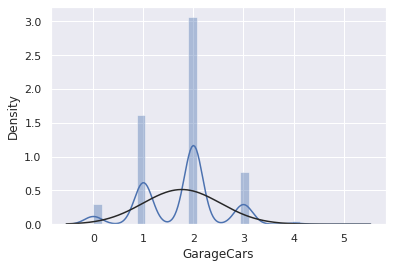

Mean of  GarageCars 1.7661179698216736
Mode of  GarageCars 0    2.0
dtype: float64


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


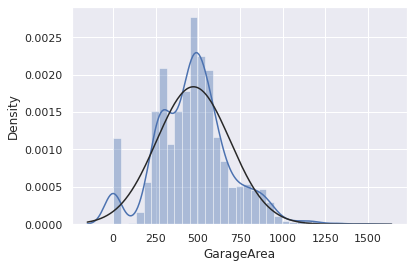

Mean of  GarageArea 472.76886145404666
Mode of  GarageArea 0    0.0
dtype: float64


In [86]:
for i in df_test[garages_test_num]:
    sns.distplot(df_test[i], fit  = norm)
    plt.show()
    print('Mean of ',str(i) , df_test[i].mean())
    print('Mode of ',str(i) , df_test[i].mode())


In [87]:
df_test['GarageYrBlt'].fillna(df_test['GarageYrBlt'].mean(), inplace = True)
df_test['GarageYrBlt'].isnull().sum()

0

In [88]:
df_test['GarageCars'].fillna(2.0, inplace = True)
df_test['GarageCars'].isnull().sum()

0

In [89]:
df_test['GarageArea'].fillna(df_test['GarageArea'].mean(), inplace = True)
df_test['GarageArea'].isnull().sum()

0

In [90]:
df_test[null2].isnull().sum()

MSZoning        4
LotFrontage     0
Utilities       2
Exterior1st     1
Exterior2nd     1
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      1
BsmtUnfSF       1
TotalBsmtSF     1
BsmtFullBath    2
BsmtHalfBath    2
KitchenQual     1
Functional      2
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageCars      0
GarageArea      0
GarageQual      0
GarageCond      0
SaleType        1
dtype: int64

### MSZoning

In [91]:
df_test['MSZoning'].mode()

0    RL
dtype: object

In [92]:
df_test['MSZoning'].fillna('RL', inplace = True)
df_test['MSZoning'].isnull().sum()

0

### Utilities

In [93]:
df_test['Utilities'].mode()

0    AllPub
dtype: object

In [94]:
df_test['Utilities'].fillna('AllPub', inplace = True)
df_test['Utilities'].isnull().sum()

0

### Exterior1st and Exterior 2nd

In [95]:
df_test['Exterior1st'].mode()

0    VinylSd
dtype: object

In [96]:
df_test['Exterior1st'].fillna('VinylSd', inplace = True)
df_test['Exterior1st'].isnull().sum()

0

In [97]:
df_test['Exterior2nd'].mode()

0    VinylSd
dtype: object

In [98]:
df_test['Exterior2nd'].fillna('VinylSd', inplace = True)
df_test['Exterior2nd'].isnull().sum()

0

### Basement features

In [99]:
bsmt_test = ['BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','BsmtFullBath', 'BsmtHalfBath']

In [100]:
df_test[bsmt_test].head()

,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,BsmtFullBath,BsmtHalfBath
0,144.0,270.0,882.0,0.0,0.0
1,0.0,406.0,1329.0,0.0,0.0
2,0.0,137.0,928.0,0.0,0.0
3,0.0,324.0,926.0,0.0,0.0
4,0.0,1017.0,1280.0,0.0,0.0


In [101]:
for col in df_test[bsmt_test].columns:
    if df_test[col].isnull().sum() > 0:
        df_test[col].fillna(df_test[col].mean(), inplace = True)

In [102]:
df_test[null2].isnull().sum()

MSZoning        0
LotFrontage     0
Utilities       0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
MasVnrArea      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
TotalBsmtSF     0
BsmtFullBath    0
BsmtHalfBath    0
KitchenQual     1
Functional      2
FireplaceQu     0
GarageType      0
GarageYrBlt     0
GarageFinish    0
GarageCars      0
GarageArea      0
GarageQual      0
GarageCond      0
SaleType        1
dtype: int64

### KitchenQual

In [103]:
df_test['KitchenQual'].mode()
df_test['KitchenQual'].fillna('TA', inplace=True)
df_test['KitchenQual'].isnull().sum()

0

### Functional

In [104]:
df_test['Functional'].mode()
df_test['Functional'].fillna('Typ', inplace=True)
df_test['Functional'].isnull().sum()

0

### SaleType

In [105]:
df_test['SaleType'].mode()
df_test['SaleType'].fillna('WD', inplace=True)
df_test['SaleType'].isnull().sum()

0

#### We should now have no null values

In [106]:
null = []

for feature in df_test.columns:
    if df_test[feature].isnull().sum() > 0:
        null.append(feature)

null

[]

In [107]:
df_test.to_csv('df_test.csv')

## 5.2 Numerical and categorical
### 5.2.1 Test: Categorical 

In [108]:
cat_test = []

for col in df_test.columns:
  if df_test[col].dtype == 'object':
    cat_test.append(col)

df_cat_test = df[cat_test]
df_cat_test.head()

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,None,Attchd,RFn,TA,TA,Y,WD,Normal
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Gd,Detchd,Unf,TA,TA,Y,WD,Abnorml
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,TA,Attchd,RFn,TA,TA,Y,WD,Normal


In [109]:
df_cat_test = df_test[cat]
print(df_cat_test.shape)
print(df_cat.shape)
print('Same amount of cat features in train than in test')

(1459, 39)
(1460, 39)
Same amount of cat features in train than in test


In [110]:
test_dummies = pd.get_dummies(df_cat_test, drop_first=False)
print(test_dummies.shape)
print(dummies.shape)
print('Somehow, dummies on train have 16 more features')

(1459, 233)
(1460, 249)
Somehow, dummies on train have 16 more features


### 5.2.2 Test: Numerical

In [111]:
num_test = []

for col in df_test.columns:
    if df_test[col].dtypes != 'object':
        num_test.append(col)
        
df_num_test = df_test[num_test]
df_num_test.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1461,20,80.0,11622,5,6,1961,1961,0.0,468.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,1462,20,81.0,14267,6,6,1958,1958,108.0,923.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,1463,60,74.0,13830,5,5,1997,1998,0.0,791.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,1464,60,78.0,9978,6,6,1998,1998,20.0,602.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,1465,120,43.0,5005,8,5,1992,1992,0.0,263.0,...,506.0,0,82,0,0,144,0,0,1,2010


In [112]:
df_num_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,...,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,20.561228,4955.517327,1.436812,1.113740,30.390071,21.130467,176.709824,455.111888,...,216.974165,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,60.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,68.580357,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,351.000000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,78.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,162.000000,752.000000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


In [113]:
print(df_num.shape)
print(df_num_test.shape)
print('Numerical DF for test has 1 less feature because the train data contains "SalePrice"')

(1460, 38)
(1459, 37)
Numerical DF for test has 1 less feature because the train data contains "SalePrice"


## 5.3 Prepare Data for modelling

In [114]:
df_num_test.isnull().sum()
print('No NaN Values for numerical')

No NaN Values for numerical


In [115]:
test_dummies.isnull().sum()
print('No NaN Values for categorical')

No NaN Values for categorical


We must concat both df to get a final df

In [116]:
df_model_test = pd.concat([df_num_test, test_dummies], axis=1)
df_model_test.shape

(1459, 270)

In [117]:
print(df_model.shape)
print(df_model_test.shape)
print('The test has 17 less features than the train DF. It also has one less row.')
print('We know that between those 17 features, one is SalePrice. The other 16 are the 16 features that the categorical DF had.')

(1460, 287)
(1459, 270)
The test has 17 less features than the train DF. It also has one less row.
We know that between those 17 features, one is SalePrice. The other 16 are the 16 features that the categorical DF had.


In [118]:
df_model_1 = df_model[:-1]

In [119]:
print(df_model_1.shape)
print(df_model_test.shape)

(1459, 287)
(1459, 270)


## 5.4 Modelling

In [120]:
X_train = df_model_1.drop('SalePrice', axis=1)
y_train = df_model_1['SalePrice']

In [121]:
X_test = df_model_test
print(X_test.shape)
print(X_train.shape)

(1459, 270)
(1459, 286)


In [122]:
final_reg = LinearRegression()
final_reg.fit(X_train, y_train)
final_reg.score(X_train, y_train)

0.9313166251678093

In [123]:
predictions = final_reg.predict(X_train)
predictions

array([205937.12182942, 206139.29819706, 204450.99610422, ...,
       213172.3344032 , 279070.48852176, 140601.69075125])

In [124]:
df_pred = pd.DataFrame(data=predictions, columns=['SalePrice'])
df_pred.head()

,SalePrice
0,205937.121829
1,206139.298197
2,204450.996104
3,164094.724267
4,291069.138762


In [125]:
df_pred['Id'] = df_test['Id']
df_pred.head()

,SalePrice,Id
0,205937.121829,1461
1,206139.298197,1462
2,204450.996104,1463
3,164094.724267,1464
4,291069.138762,1465


In [126]:
df_pred = df_pred[['Id', 'SalePrice']]
df_pred.head()


,Id,SalePrice
0,1461,205937.121829
1,1462,206139.298197
2,1463,204450.996104
3,1464,164094.724267
4,1465,291069.138762


In [127]:
df_pred.to_csv('predictions.csv' , index=False)



In [128]:
df_pred.to_csv('preditions.csv')

In [129]:
df_pred.to_csv('df_predictions.csv')

In [130]:
df_pred['SalePrice']

0       205937.121829
1       206139.298197
2       204450.996104
3       164094.724267
4       291069.138762
            ...      
1454    192244.583877
1455    174950.974959
1456    213172.334403
1457    279070.488522
1458    140601.690751
Name: SalePrice, Length: 1459, dtype: float64